
Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - AUC: 0.4993 - loss: 0.4012 - val_AUC: 0.7356 - val_loss: 0.1004
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - AUC: 0.6394 - loss: 0.1316 - val_AUC: 0.7459 - val_loss: 0.0989
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - AUC: 0.6740 - loss: 0.1182 - val_AUC: 0.7346 - val_loss: 0.1000
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - AUC: 0.7057 - loss: 0.1197 - val_AUC: 0.7446 - val_loss: 0.0990
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - AUC: 0.6651 - loss: 0.1340 - val_AUC: 0.7517 - val_loss: 0.0986
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - AUC: 0.7103 - loss: 0.1266 - val_AUC: 0.7542 - val_loss: 0.0984
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - AUC: 0.6943 - loss: 0.1226 - val_AUC: 0.7472 - val_loss: 0.0991
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - AUC: 0.7018 - loss: 0.1326 - val_AUC: 0.7397 - val_loss: 0.0994
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/st

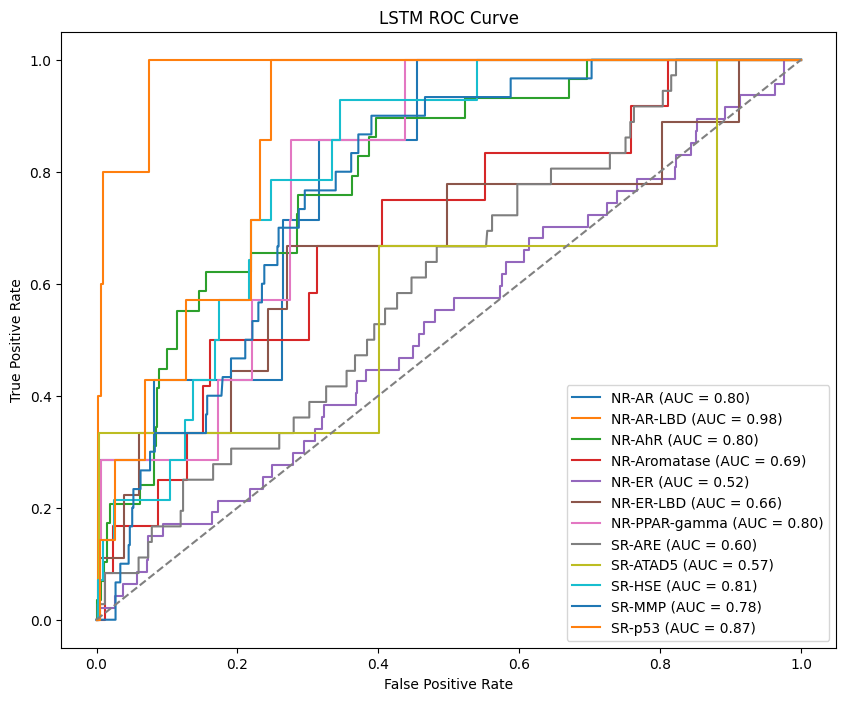


Training BiLSTM...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - AUC: 0.5413 - loss: 0.3616 - val_AUC: 0.7290 - val_loss: 0.0996
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - AUC: 0.6835 - loss: 0.1256 - val_AUC: 0.7375 - val_loss: 0.0996
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - AUC: 0.6996 - loss: 0.1134 - val_AUC: 0.7494 - val_loss: 0.0991
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - AUC: 0.7008 - loss: 0.1226 - val_AUC: 0.7455 - val_loss: 0.0987
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - AUC: 0.7298 - loss: 0.1161 - val_AUC: 0.7602 - val_loss: 0.1018
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - AUC: 0.7383 - loss: 0.1225 - val_AUC: 0.7722 - val_loss: 0.0966
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - AUC: 0.7639 - loss: 0.1190 - val_AUC: 0.7686 - val_loss: 0.0965
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - AUC: 0.7662 - loss: 0.1111 - val_AUC: 0.7717 - val_loss: 0.0964
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - AUC:

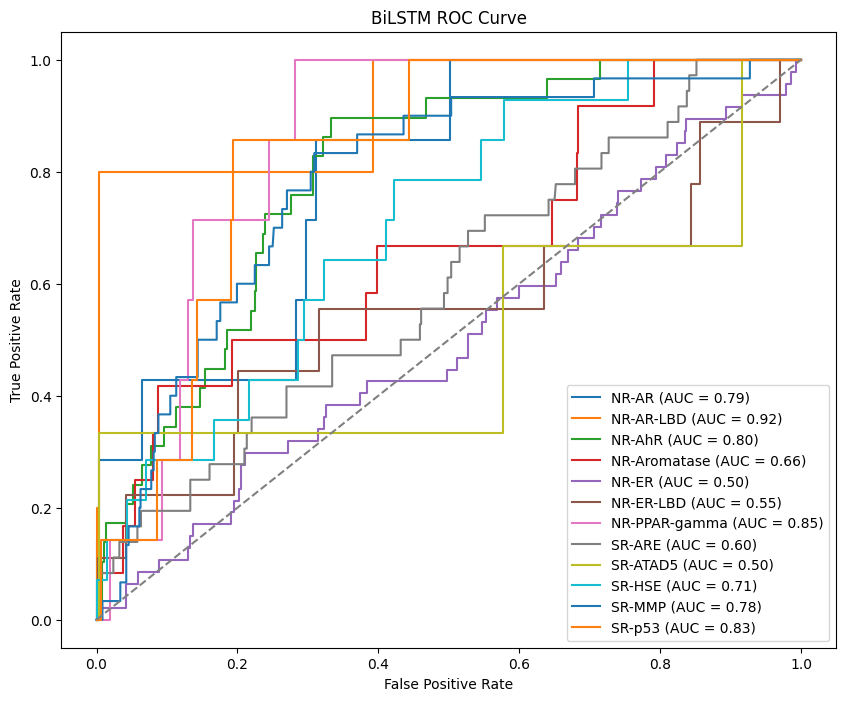


Training 1D-CNN...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - AUC: 0.5383 - loss: 0.4169 - val_AUC: 0.6805 - val_loss: 0.1030
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - AUC: 0.6936 - loss: 0.1244 - val_AUC: 0.7091 - val_loss: 0.1012
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.6800 - loss: 0.1283 - val_AUC: 0.7166 - val_loss: 0.1009
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - AUC: 0.7064 - loss: 0.1268 - val_AUC: 0.6997 - val_loss: 0.1018
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - AUC: 0.7254 - loss: 0.1188 - val_AUC: 0.7444 - val_loss: 0.1000
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - AUC: 0.7545 - loss: 0.1243 - val_AUC: 0.7376 - val_loss: 0.0997
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - AUC: 0.7619 - loss: 0.1203 - val_AUC: 0.7392 - val_loss: 0.0993
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - AUC: 0.7851 - loss: 0.1150 - val_AUC: 0.7555 - val_loss: 0.0979
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - AUC: 0.7791 - loss: 0.

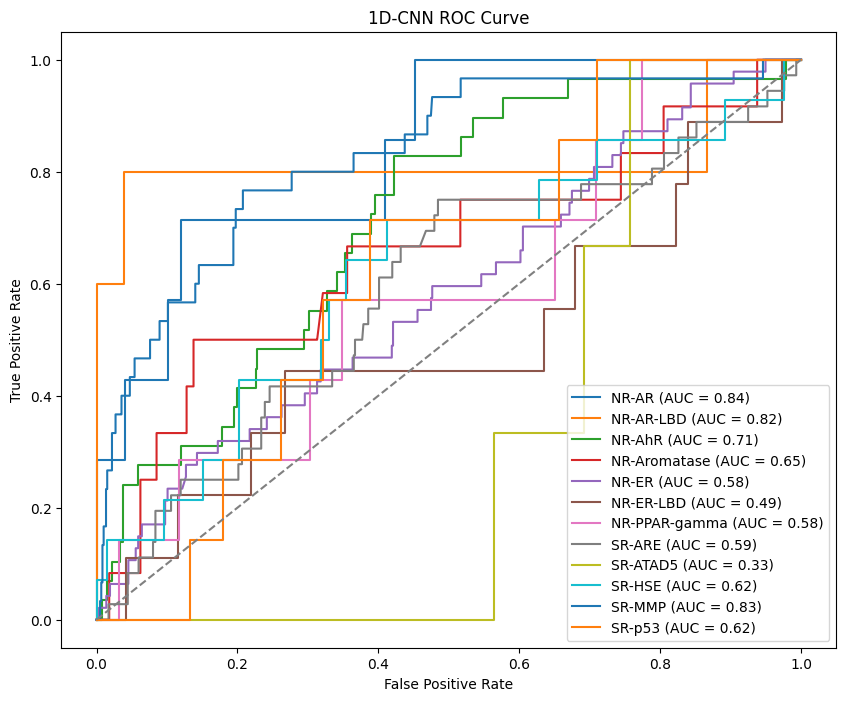

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# === Load & Clean ===
df = pd.read_csv("tox21.csv")
targets = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase", "NR-ER", "NR-ER-LBD",
    "NR-PPAR-gamma", "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]
df = df.dropna(subset=["smiles"] + targets)
smiles = df["smiles"].astype(str).tolist()
Y = df[targets].astype(int).values

# === Tokenize SMILES ===
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles)
sequences = tokenizer.texts_to_sequences(smiles)
X = pad_sequences(sequences, maxlen=200)
vocab_size = len(tokenizer.word_index) + 1

# === Train/test split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

def plot_roc_curve(y_true, y_pred, name):
    plt.figure(figsize=(10, 8))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{targets[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# === Helper: Evaluate ROC-AUC per target ===
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    aucs = []
    accuracies = []

    for i in range(Y.shape[1]):
        try:
            auc = roc_auc_score(Y_test[:, i], y_pred[:, i])
        except ValueError:
            auc = np.nan  # In case of constant labels
        aucs.append(auc)
    print(f"\n{name} ROC-AUCs:")
    for i, target in enumerate(targets):
        print(f"{target:15s}: ROC-AUC = {aucs[i]:.3f}")
    plot_roc_curve(Y_test, y_pred, name)
    return aucs

# === 1. LSTM Model ===
def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        LSTM(64),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

# === 2. BiLSTM Model ===
def build_bilstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

# === 3. 1D-CNN Model ===
def build_cnn():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=200),
        Conv1D(128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(12, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model

# === Train & Evaluate Each ===
for name, builder in [("LSTM", build_lstm), ("BiLSTM", build_bilstm), ("1D-CNN", build_cnn)]:
    print(f"\nTraining {name}...")
    model = builder()
    model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
    evaluate_model(model, name)